In [1]:
%matplotlib inline
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt, csv
import time
from pprint import pprint as print

## Convenience Classes

The 'City' class allows us to easily measure distance between cities. A list of cities is called a route, and will be our chromosome for this genetic algorithm.

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Fitness class used to calculate distance and fitness of a route

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator using 3 functions to generate a large population of randomly generated chromosomes

In [4]:
def genCityList(filename):
    cityList = []
    #TODO - implement this function by replacing the code between the TODO lines
    file = open(filename,'r')
    for line in file:
             stringArray = line.split()
             cityList.append(City(x=int(stringArray[1]), y=int(stringArray[2])))
    file.close()
    #TODO - the code above just generates 12 cities (useful for testing)
    return cityList

In [5]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)

In [6]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

## Create the genetic algorithm

Rank individuals to create a good mating pool

In [7]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

In [8]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [9]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [10]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [11]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

In [12]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [13]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [14]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

In [15]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    
    start_time = time.time()
    
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    #for i in range(generations):
    #pop = nextGeneration(pop, eliteSize, mutationRate)
        #distances = [Fitness(p).routeDista
       #nce() for p in pop]
        #min_dist = min(distances)
        #print("Best Distance for population in iteration: " + str(i) + str(min_dist))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]

    end_time = time.time()
    print("Time taken: {} s".format(end_time-start_time))
        
    return bestRoute

## Running the genetic algorithm

Create list of cities

Run the genetic algorithm

In [16]:
cityList = genCityList('tsp-case04.txt')
geneticAlgorithm(population=cityList, popSize=100, eliteSize=10, mutationRate=0.01, generations=500)


'Initial distance: 41591202.32427467'
'Final distance: 40911969.7015657'
'Time taken: 27211.51580762863 s'


[(4768,7209),
 (4285,4325),
 (5069,6992),
 (4045,4498),
 (3848,8843),
 (6041,2613),
 (7684,3082),
 (6044,3854),
 (3447,4664),
 (6574,5602),
 (3570,7349),
 (4525,5350),
 (5069,4507),
 (4514,9062),
 (4299,3993),
 (4848,3222),
 (5772,9297),
 (2985,5495),
 (5931,4312),
 (3177,6887),
 (3292,5375),
 (8141,3642),
 (5795,3398),
 (3902,4696),
 (3996,7616),
 (6794,4376),
 (5564,10606),
 (3779,5878),
 (5535,7998),
 (5354,4186),
 (5491,7074),
 (5574,3381),
 (4452,4259),
 (3974,2712),
 (4121,6180),
 (3891,9320),
 (6130,3354),
 (6586,3577),
 (5693,7640),
 (4866,6716),
 (4760,7169),
 (5021,8150),
 (4053,6237),
 (5824,10299),
 (6651,8775),
 (6207,5495),
 (6362,4109),
 (4781,6257),
 (6849,5519),
 (5664,9425),
 (3558,7206),
 (5960,4781),
 (4001,5548),
 (3785,4777),
 (6182,9964),
 (5486,4287),
 (5316,3549),
 (7400,3216),
 (5080,9826),
 (3987,8746),
 (4141,6195),
 (4209,5250),
 (5670,10186),
 (5036,10656),
 (7481,3058),
 (6404,8849),
 (5100,5414),
 (5479,3871),
 (4008,7036),
 (6962,3769),
 (3883,6327),
 (

## Plot the progress

Note, this will win run a separate GA

In [17]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Iteration Limit')
    plt.show()

Run the function with our assumptions to see how distance has improved in each generation

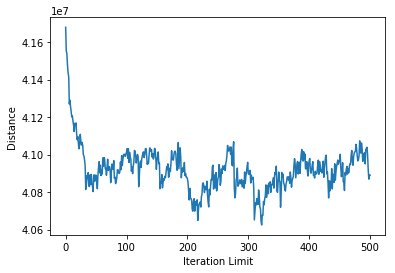

In [18]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=10, mutationRate=0.01, generations=250)

In [1]:
def text(population, popSize, eliteSize, mutationRate, generations):

filename = 'mysolution.csv'
pop = nextGeneration(population, eliteSize, mutationRate)
index = rankRoutes(pop)[0][0]
best_route = pop[index]
with open('mysolution.csv', mode='w') as f:
    writer = csv.writer(f, delimiter=' ', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(len(best_route)):
        writer.writerow([i, best_route[i].x, best_route[i].y])

IndentationError: expected an indented block (<ipython-input-1-783510edb4aa>, line 3)